In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
import warnings

In [2]:
# 경고 메시지 무시
warnings.filterwarnings('ignore')

In [3]:
# Matplotlib 한글 폰트 설정 (Windows 버전)
# 윈도우 환경의 기본 한글 폰트인 'Malgun Gothic'으로 설정합니다.
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# 1. 데이터 읽기
file_name = 'store_data.csv'
df = pd.read_csv(file_name, parse_dates=['주문 일자', '배송 일자'])
print(f"'{file_name}' 파일 로드 완료.\n")

'store_data.csv' 파일 로드 완료.



In [5]:
print("--- '전체 고객' 대상 '이탈/우수/일반' 분류 기준(RFM) EDA 시작 ---")
print("(신규/기존 구분 없이 795명 전체를 대상으로 합니다.)\n")

--- '전체 고객' 대상 '이탈/우수/일반' 분류 기준(RFM) EDA 시작 ---
(신규/기존 구분 없이 795명 전체를 대상으로 합니다.)



In [6]:
# --- 2. '전체 고객' 대상 RFM 데이터 집계 ---
# (신규/기존 구분 없이 795명 모두)

# 2-1. 분석 기준일(Snapshot Date) 설정
snapshot_date = df['주문 일자'].max() + pd.Timedelta(days=1)
print(f"분석 기준일: {snapshot_date.date()}")

# 2-2. RFM 집계 (전체 고객 대상)
rfm_all_df = df.groupby('고객번호').agg(
    Recency=('주문 일자', lambda x: (snapshot_date - x.max()).days),
    Frequency=('주문 번호', 'nunique'),
    Monetary=('매출', 'sum')
).reset_index()

print(f"\n총 {len(rfm_all_df)}명 전체 고객 RFM 집계 완료.")
print(rfm_all_df)

분석 기준일: 2025-01-01

총 795명 전체 고객 RFM 집계 완료.
         고객번호  Recency  Frequency      Monetary
0    AA-10315        9          5  1.474314e+06
1    AA-10375        7          4  2.455390e+06
2    AA-10480      126          5  6.064347e+06
3    AA-10645       29         12  5.369371e+06
4    AB-10015      114          9  1.087323e+07
..        ...      ...        ...           ...
790  XP-21865      131          7  3.777240e+06
791  YC-21895      474          4  5.718946e+06
792  YS-21880      234          4  3.616461e+06
793  ZC-21910       37          7  7.595060e+06
794  ZD-21925       19          5  1.927043e+06

[795 rows x 4 columns]



--- 3. '이탈 위험' 기준(R) EDA (전체 고객 대상) ---
'전체 고객' Recency 75% (Q3) 지점: 173일
'전체 고객' Recency 80% 지점: 207일
(해석: '전체 고객'의 25%는 173일 이상 구매가 없었습니다.)


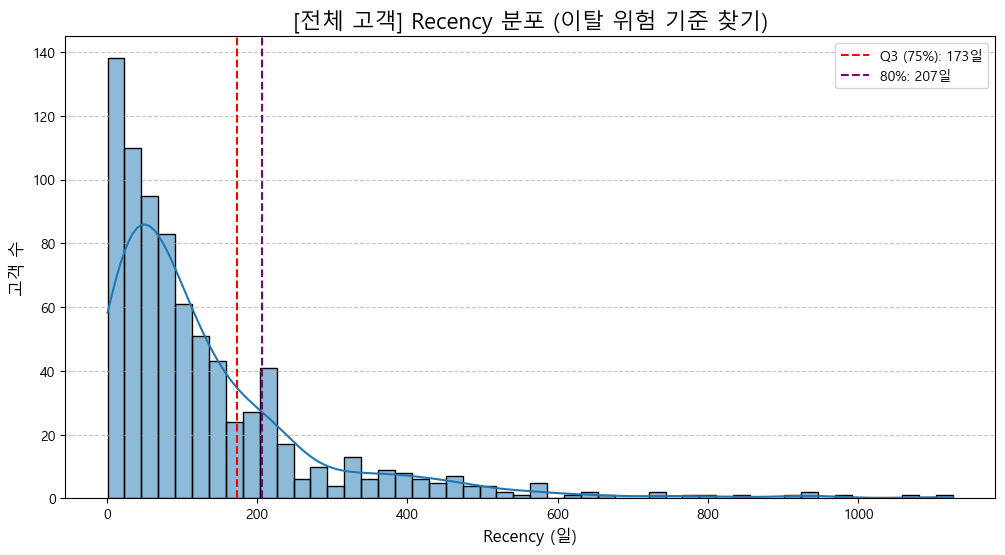

In [7]:
# --- 3. '이탈 위험' 기준 분석 (Recency) ---
print("\n--- 3. '이탈 위험' 기준(R) EDA (전체 고객 대상) ---")

# 3-1. Recency 통계
r_q3 = rfm_all_df['Recency'].quantile(0.75) # 75% (Q3)
r_q4 = rfm_all_df['Recency'].quantile(0.80) # 80%
print(f"'전체 고객' Recency 75% (Q3) 지점: {r_q3:.0f}일")
print(f"'전체 고객' Recency 80% 지점: {r_q4:.0f}일")
print(f"(해석: '전체 고객'의 25%는 {r_q3:.0f}일 이상 구매가 없었습니다.)")

# 3-2. Recency 히스토그램
plt.figure(figsize=(12, 6))
sns.histplot(rfm_all_df['Recency'], bins=50, kde=True)
plt.title('[전체 고객] Recency 분포 (이탈 위험 기준 찾기)', fontsize=16)
plt.xlabel('Recency (일)', fontsize=12)
plt.ylabel('고객 수', fontsize=12)
plt.axvline(r_q3, color='red', linestyle='--', label=f'Q3 (75%): {r_q3:.0f}일')
plt.axvline(r_q4, color='purple', linestyle='--', label=f'80%: {r_q4:.0f}일')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show() # Jupyter Notebook에서 바로 보기


--- 4. '우수 고객' 기준(F/M) EDA ---
Recency < 173일 ('활성 고객') 595명을 대상으로 F/M 기준을 분석합니다.
'활성 고객' Frequency 75% (Q3) 지점: 9회
'활성 고객' Monetary 75% (Q3) 지점: 6,547,279원


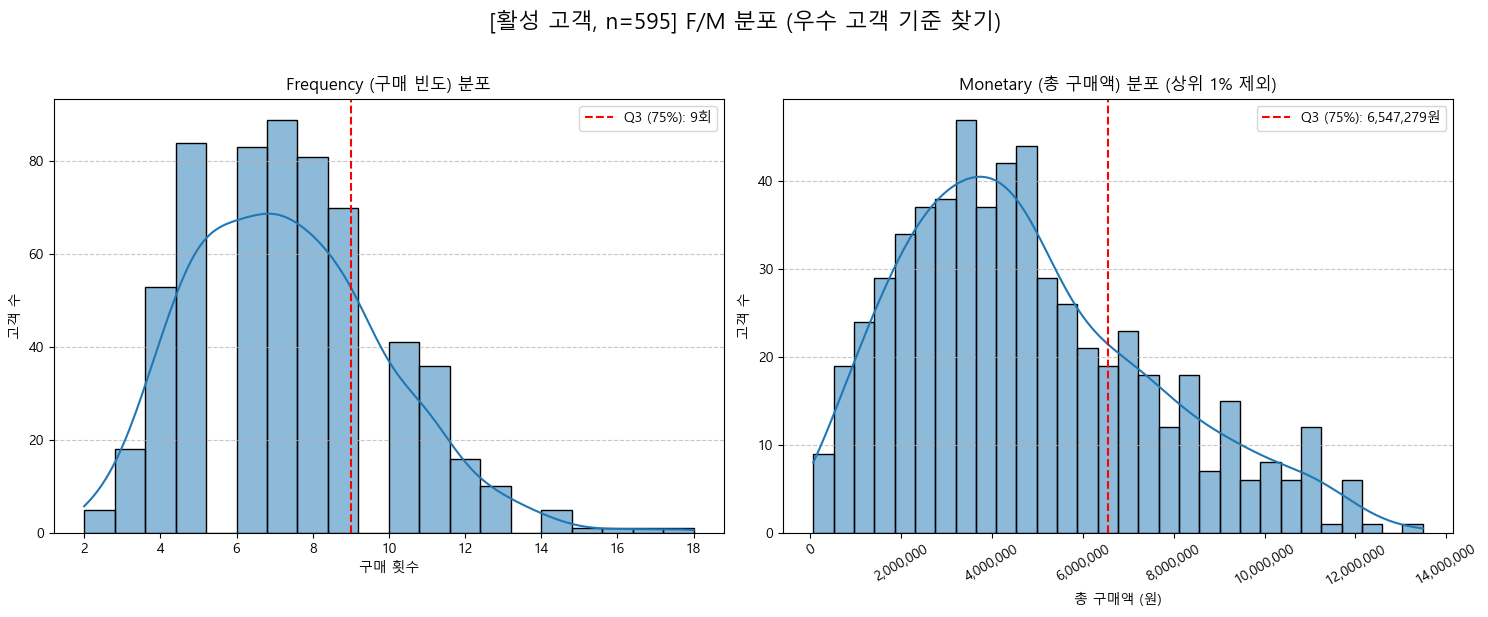

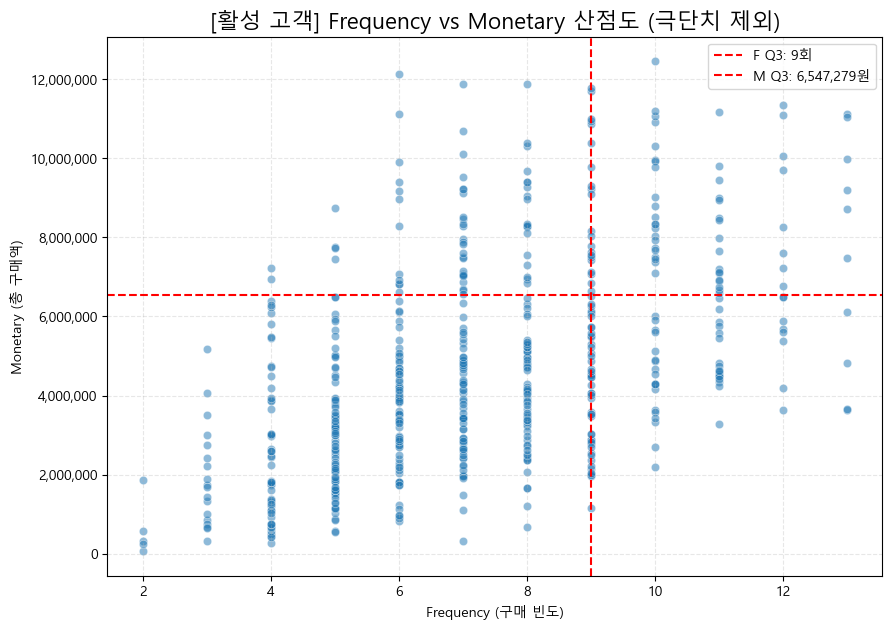


--- RFM 기준 EDA 완료 ---


In [8]:
# --- 4. '우수 고객' 기준 분석 (Frequency & Monetary) ---
print("\n--- 4. '우수 고객' 기준(F/M) EDA ---")

# 4-1. '활성 고객'(Not At-Risk) 데이터 추출
# (예시: '이탈 위험' 기준을 Q3(75%)로 가정)
R_CUTOFF = r_q3 
active_rfm_df = rfm_all_df[rfm_all_df['Recency'] < R_CUTOFF]
print(f"Recency < {R_CUTOFF:.0f}일 ('활성 고객') {len(active_rfm_df)}명을 대상으로 F/M 기준을 분석합니다.")

if not active_rfm_df.empty:
    # 4-2. F/M 통계 (활성 고객 기준)
    f_q3 = active_rfm_df['Frequency'].quantile(0.75)
    m_q3 = active_rfm_df['Monetary'].quantile(0.75)
    print(f"'활성 고객' Frequency 75% (Q3) 지점: {f_q3:.0f}회")
    print(f"'활성 고객' Monetary 75% (Q3) 지점: {m_q3:,.0f}원")

    # 4-3. F/M 히스토그램 (서브플롯)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'[활성 고객, n={len(active_rfm_df)}] F/M 분포 (우수 고객 기준 찾기)', fontsize=16, y=1.02)

    # Frequency 히스토그램
    sns.histplot(active_rfm_df['Frequency'], bins=20, kde=True, ax=ax1)
    ax1.set_title('Frequency (구매 빈도) 분포')
    ax1.set_xlabel('구매 횟수')
    ax1.set_ylabel('고객 수')
    ax1.axvline(f_q3, color='red', linestyle='--', label=f'Q3 (75%): {f_q3:.0f}회')
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Monetary 히스토그램 (상위 1% 극단치 제외)
    m_cap = active_rfm_df['Monetary'].quantile(0.99)
    sns.histplot(active_rfm_df[active_rfm_df['Monetary'] < m_cap]['Monetary'], bins=30, kde=True, ax=ax2)
    ax2.set_title('Monetary (총 구매액) 분포 (상위 1% 제외)')
    ax2.set_xlabel('총 구매액 (원)')
    ax2.set_ylabel('고객 수')
    ax2.axvline(m_q3, color='red', linestyle='--', label=f'Q3 (75%): {m_q3:,.0f}원')
    ax2.legend()
    ax2.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=30)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show() # Jupyter Notebook에서 바로 보기

    # 4-4. F vs M 산점도 (활성 고객 대상)
    plt.figure(figsize=(10, 7))
    # 극단치 제외 (F/M 99% quantile)
    f_cap = active_rfm_df['Frequency'].quantile(0.99)
    plot_scatter_df = active_rfm_df[
        (active_rfm_df['Monetary'] < m_cap) & 
        (active_rfm_df['Frequency'] < f_cap)
    ]
    
    sns.scatterplot(data=plot_scatter_df, x='Frequency', y='Monetary', alpha=0.5)
    
    # Q3 기준선 그리기
    plt.axvline(f_q3, color='red', linestyle='--', label=f'F Q3: {f_q3:.0f}회')
    plt.axhline(m_q3, color='red', linestyle='--', label=f'M Q3: {m_q3:,.0f}원')
    
    plt.title(f'[활성 고객] Frequency vs Monetary 산점도 (극단치 제외)', fontsize=16)
    plt.xlabel('Frequency (구매 빈도)')
    plt.ylabel('Monetary (총 구매액)')
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show() # Jupyter Notebook에서 바로 보기

else:
    print("'활성 고객'이 없어 F/M 분석을 생략합니다.")

print("\n--- RFM 기준 EDA 완료 ---")

In [9]:
# --- 5. 세그먼트 분류 기준 설정 ---
# 5-1. 이탈 위험 기준 (R)
R_CUTOFF = 173
print(f"[이탈 위험] 기준: Recency >= {R_CUTOFF}일")

# 5-2. 우수 고객 기준 (F/M) - 'AND' 조건
F_CUTOFF = 9
M_CUTOFF = 6547279
print(f"[우수 고객] 기준: Recency < {R_CUTOFF}일 AND Frequency >= {F_CUTOFF}회 AND Monetary >= {M_CUTOFF:,.0f}원")
print(f"[일반 고객] 기준: 위 2개에 해당하지 않는 모든 고객")

# --- 6. 세그먼트 분류 적용 ---
# 분류 로직을 적용할 함수 정의
def segment_customer(row):
    # 1순위: '이탈 위험'
    if row['Recency'] >= R_CUTOFF:
        return '이탈 위험'
    # 2순위: '우수'
    # 기준: (R < 173) AND (F >= 9) AND (M >= 6547279)
    # (R < 173은 1순위에서 이미 걸러졌으므로 R 조건은 생략 가능)
    elif (row['Frequency'] >= F_CUTOFF) and (row['Monetary'] >= M_CUTOFF):
        return '우수'
    # 3순위: '일반'
    else:
        return '일반'

# 위 함수를 모든 행(axis=1)에 적용하여 'Segment' 컬럼 생성
rfm_all_df['Segment'] = rfm_all_df.apply(segment_customer, axis=1)

# --- 7. 분류 결과 확인 ---
print("\n--- 세그먼트 분류 결과 ---")
segment_counts = rfm_all_df['Segment'].value_counts()
print(segment_counts)

[이탈 위험] 기준: Recency >= 173일
[우수 고객] 기준: Recency < 173일 AND Frequency >= 9회 AND Monetary >= 6,547,279원
[일반 고객] 기준: 위 2개에 해당하지 않는 모든 고객

--- 세그먼트 분류 결과 ---
Segment
일반       511
이탈 위험    200
우수        84
Name: count, dtype: int64
